In [ ]:
from collections import defaultdict
import math
import scipy.optimize
import numpy
import string
from sklearn import linear_model
import random
import gzip
from collections import defaultdict
import math
import scipy.optimize
import numpy
import string
import random
from sklearn import linear_model
import numpy as np
import pandas as pd

In [23]:


paths = ["australian_users_items.json.gz", "australian_user_reviews.json.gz", "bundle_data.json.gz", "steam_games.json.gz", "steam_reviews.json.gz"]

# 1. Initialize a dictionary to hold your datasets
dfs = {} 

for path in paths:
    print(f"Processing {path}...")
    
    # 2. CRITICAL: Reset the list for each new file!
    data_list = []
    
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            try:
                record = eval(line)
                data_list.append(record)
            except SyntaxError:
                continue

    # 3. Use the filename as the dictionary key
    name = path.split(".")[0] 
    dfs[name] = pd.DataFrame(data_list)
    print(f"-> Loaded {name} ({len(data_list)} rows)")

# ---------------------------------------------------------
# HOW TO ACCESS YOUR DATA NOW
# ---------------------------------------------------------

# You can access them from the dictionary:
print(dfs['australian_users_items'].head())

# OR, if you really want them as separate variables now:
australian_users_items = dfs['australian_users_items']
steam_games = dfs['steam_games']

Processing australian_users_items.json.gz...
-> Loaded australian_users_items (88310 rows)
Processing australian_user_reviews.json.gz...
-> Loaded australian_user_reviews (25799 rows)
Processing bundle_data.json.gz...
-> Loaded bundle_data (615 rows)
Processing steam_games.json.gz...
-> Loaded steam_games (32135 rows)
Processing steam_reviews.json.gz...
-> Loaded steam_reviews (7793069 rows)
             user_id  items_count           steam_id  \
0  76561197970982479          277  76561197970982479   
1            js41637          888  76561198035864385   
2          evcentric          137  76561198007712555   
3         Riot-Punch          328  76561197963445855   
4              doctr          541  76561198002099482   

                                            user_url  \
0  http://steamcommunity.com/profiles/76561197970...   
1               http://steamcommunity.com/id/js41637   
2             http://steamcommunity.com/id/evcentric   
3            http://steamcommunity.com/id/Ri

In [24]:

australian_users_items = dfs['australian_users_items']
australian_user_reviews = dfs['australian_user_reviews']
bundle_data = dfs['bundle_data']
steam_games = dfs['steam_games']
steam_reviews = dfs['steam_reviews']

[{'item_id': '10',
  'item_name': 'Counter-Strike',
  'playtime_forever': 6,
  'playtime_2weeks': 0},
 {'item_id': '20',
  'item_name': 'Team Fortress Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '30',
  'item_name': 'Day of Defeat',
  'playtime_forever': 7,
  'playtime_2weeks': 0},
 {'item_id': '40',
  'item_name': 'Deathmatch Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '50',
  'item_name': 'Half-Life: Opposing Force',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '60',
  'item_name': 'Ricochet',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '70',
  'item_name': 'Half-Life',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '130',
  'item_name': 'Half-Life: Blue Shift',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '300',
  'item_name': 'Day of Defeat: Source',
  'playtime_forever': 4733,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: S

In [34]:
# Get the list of items for the first user
user_items = australian_users_items.iloc[0]['items']

# Iterate through each item
for item in user_items:
    item_id = item['item_id']
    
    # Filter steam_games to find the row where 'id' matches 'item_id'
    # We use .loc[condition, 'column_name']
    price = steam_games.loc[steam_games['id'] == item_id, 'price']
    
    # Check if we actually found a match (some items might not be in the games database)
    if not price.empty:
        print(f"Item ID: {item_id} | Price: {price.values[0]}")
    else:
        print(f"Item ID: {item_id} | Price: Not Found")

Item ID: 10 | Price: 9.99
Item ID: 20 | Price: 4.99
Item ID: 30 | Price: 4.99
Item ID: 40 | Price: 4.99
Item ID: 50 | Price: 4.99
Item ID: 60 | Price: 4.99
Item ID: 70 | Price: 9.99
Item ID: 130 | Price: 4.99
Item ID: 300 | Price: 9.99
Item ID: 240 | Price: 19.99
Item ID: 3830 | Price: 9.99
Item ID: 2630 | Price: 19.99
Item ID: 3900 | Price: 19.99
Item ID: 34440 | Price: Not Found
Item ID: 3920 | Price: 9.99
Item ID: 6400 | Price: 9.99
Item ID: 6910 | Price: 6.99
Item ID: 7670 | Price: 19.99
Item ID: 409710 | Price: 19.99
Item ID: 220 | Price: 9.99
Item ID: 320 | Price: 4.99
Item ID: 340 | Price: nan
Item ID: 360 | Price: 9.99
Item ID: 380 | Price: 7.99
Item ID: 400 | Price: 9.99
Item ID: 420 | Price: 7.99
Item ID: 9340 | Price: Not Found
Item ID: 228200 | Price: Not Found
Item ID: 11450 | Price: 4.99
Item ID: 7940 | Price: 19.99
Item ID: 4700 | Price: 19.99
Item ID: 12900 | Price: 9.99
Item ID: 13250 | Price: 9.99
Item ID: 16100 | Price: 9.99
Item ID: 15700 | Price: 2.99
Item ID: 1571

In [40]:
import numpy as np

def clean_price(price):
    # 1. If it's already a number (float/int), return it
    if isinstance(price, (int, float)):
        return price
    
    # 2. If it's a string, clean it
    if isinstance(price, str):
        price = price.lower().strip()
        
        # Handle "Free" variations
        if 'free' in price:
            return 0.0
        
        # Handle "Third-party" or other non-price text
        if 'third' in price:
            return np.nan

        try:
            # Remove symbols like '$' if they exist and convert to float
            return float(price.replace('$', ''))
        except ValueError:
            # If conversion fails (e.g. empty string), return NaN
            return np.nan

    # 3. Default fallback
    return np.nan

# --- APPLY THE FUNCTION ---
merged_df = steam_games.copy()
# 1. Apply cleaning
# (Assuming your merged dataframe is called 'merged_df')
merged_df['price'] = merged_df['price'].apply(clean_price)

# 2. Calculate the Median of the VALID prices (ignoring NaNs)
median_price = merged_df['price'].median()
print(f"Imputing missing prices with the median: ${median_price}")

# 3. Fill the 'Not Found' / NaN values with the median
merged_df['price'] = merged_df['price'].fillna(median_price)

# Check the result
print(merged_df[['id', 'price']].head(10))

Imputing missing prices with the median: $4.99
       id  price
0  761140   4.99
1  643980   0.00
2  670290   0.00
3  767400   0.99
4  773570   2.99
5  772540   3.99
6  774276   9.99
7  774277  18.99
8  774278  29.99
9  768800   4.99


In [56]:
import numpy as np
import pandas as pd

def resolve_final_price(row):
    price = row['price']
    discount = row['discount_price']
    
    # --- Helper: Try to turn any value into a float ---
    def parse_value(val):
        # 1. If it's already a clean number, return it
        if isinstance(val, (int, float)):
            if np.isnan(val): return None
            return float(val)
            
        # 2. If it's a string, clean it
        if isinstance(val, str):
            text = val.lower().strip()
            if 'free' in text: return 0.0
            try:
                # Remove currency symbols and commas
                return float(text.replace('$', '').replace(',', ''))
            except ValueError:
                return None
        return None

    # --- MAIN LOGIC ---

    # 1. Try to get the Discount Price first
    d_val = parse_value(discount)
    if d_val is not None:
        return d_val
    
    # 2. If Discount is missing/invalid, Fallback to Regular Price
    p_val = parse_value(price)
    if p_val is not None:
        return p_val
        
    # 3. If both are missing, return NaN
    return np.nan

# --- APPLY THE FUNCTION ---
merged_df = steam_games.copy()

print("Calculating final prices...")
# axis=1 is crucial to access both columns row-by-row
merged_df['final_price'] = merged_df.apply(resolve_final_price, axis=1)

# Now check specifically for rows where you had missing discounts
# This shows rows where discount was NaN but price existed
check_mask = (merged_df['discount_price'].isna()) & (merged_df['price'].notna())
print("\nSample of rows where we fell back to regular price:")
print(merged_df.loc[check_mask, ['price', 'discount_price', 'final_price']].head())

# Finally, fill any remaining TOTAL failures with the median
median_price = merged_df['final_price'].median()
print(f"\nImputing remaining {merged_df['final_price'].isna().sum()} missing values with median: {median_price} because mean was {merged_df['final_price'].mean()}")
merged_df['final_price'] = merged_df['final_price'].fillna(median_price)

Calculating final prices...

Sample of rows where we fell back to regular price:
          price  discount_price  final_price
1  Free To Play             NaN         0.00
2  Free to Play             NaN         0.00
5          3.99             NaN         3.99
6          9.99             NaN         9.99
7         18.99             NaN        18.99

Imputing remaining 1322 missing values with median: 4.99 because mean was 8.903959043260961


In [53]:
steam_games[steam_games['id'] == "772540"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
5,Trickjump Games Ltd,"[Action, Adventure, Simulation]",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018-01-04,"[Action, Adventure, Simulation, FPS, Shooter, ...",NaN,http://steamcommunity.com/app/772540/reviews/?...,"[Single-player, Steam Achievements]",3.99,False,772540,Trickjump Games Ltd,Mixed,NaN


In [67]:
import pandas as pd

# --- STEP 1: PREPARE THE GAMES DATA ---
# We only need ID and Tags. 
# Drop games with no tags to avoid errors later.
games_tags = steam_games[['id', 'tags']].dropna(subset=['tags']).copy()

# Ensure IDs are strings to match the user data format
games_tags['id'] = games_tags['id'].astype(str)

# --- STEP 2: PREPARE THE USER DATA ---
# We keep only user_id and items to save memory
users_minimal = australian_users_items[['user_id', 'items']].copy()

# 1. Explode: Turn one row per user into one row per game owned
print("Exploding user items...")
user_exploded = users_minimal.explode('items')

# 2. Extract item_id from the dictionaries
# (Handle potential NaNs if a user has 0 items)
user_exploded = user_exploded.dropna(subset=['items'])
user_exploded['item_id'] = user_exploded['items'].apply(lambda x: str(x['item_id']))

# --- STEP 3: MERGE ---
# Connect the User's Game ID to the Game's Tags
print("Merging data...")
merged = user_exploded.merge(games_tags, left_on='item_id', right_on='id', how='inner')

# --- STEP 4: AGGREGATE (THEME CREATION) ---
# Group by User and combine all tag lists into one big set
print("Grouping preferences...")

def get_unique_tags(series_of_lists):
    # 1. Flatten the series of lists into one long list
    # 2. Convert to set to remove duplicates
    all_tags = [tag for sublist in series_of_lists for tag in sublist]
    return set(all_tags)

user_preferences = merged.groupby('user_id')['tags'].apply(get_unique_tags).reset_index()
user_preferences.rename(columns={'tags': 'preference_set'}, inplace=True)

# --- RESULT ---
print(user_preferences.head())

Exploding user items...
Merging data...
Grouping preferences...
             user_id                                     preference_set
0            --000--  {Nudity, Cyberpunk, Mechs, Story Rich, Clicker...
1            --ace--  {Movie, Story Rich, Clicker, Sniper, Military,...
2          --ionex--  {Story Rich, Clicker, Runner, Military, Free t...
3       -2SV-vuLB-Kg  {Nudity, Cyberpunk, Mechs, Story Rich, Transhu...
4  -404PageNotFound-  {Nudity, Cyberpunk, Mechs, Story Rich, Clicker...


In [68]:
# Convert list to tuple, then count
# We sort the tuple so that ['Action', 'FPS'] is treated the same as ['FPS', 'Action']
counts = user_preferences['preference_set'].apply(lambda x: tuple(sorted(x))).value_counts()

print(counts.head())

preference_set
(Action, Adventure, Co-op, FPS, First-Person, Gore, Horror, Local Co-Op, Moddable, Multiplayer, Online Co-Op, Post-apocalyptic, Replay Value, Shooter, Singleplayer, Survival, Survival Horror, Tactical, Team-Based, Zombies)    244
(Action, Adventure, Animation & Modeling, Building, Co-op, Comedy, FPS, First-Person, Funny, Indie, Massively Multiplayer, Mod, Moddable, Multiplayer, Online Co-Op, Physics, Sandbox, Shooter, Simulation, Singleplayer)         221
(Action, Adventure, Atmospheric, Casual, Co-op, Crafting, FPS, First-Person, Free to Play, Horror, Indie, Massively Multiplayer, Multiplayer, Open World, Post-apocalyptic, Sandbox, Shooter, Singleplayer, Survival, Zombies)    205
(Action, Co-op, Competitive, Difficult, FPS, Fast-Paced, First-Person, Military, Moddable, Multiplayer, Online Co-Op, PvP, Realistic, Shooter, Strategy, Tactical, Team-Based, Trading, War, e-sports)                            196
(2D, Action, Adventure, Atmospheric, Building, Co-op, Crafting, E

In [86]:
australian_user_reviews.iloc[0]['reviews']

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

In [87]:
import pandas as pd

# 1. Explode the list of reviews
reviews_exploded = australian_user_reviews.explode('reviews')

# 2. Normalize (convert dictionary keys to columns)
reviews_normalized = pd.json_normalize(reviews_exploded['reviews'])

# 3. Attach User ID back (since normalize drops it)
reviews_normalized['user_id'] = reviews_exploded['user_id'].values

# 4. Clean empty reviews (optional but recommended)
reviews_df = reviews_normalized.dropna(subset=['review'])

print(reviews_df[['user_id', 'item_id', 'review']].head())

             user_id item_id  \
0  76561197970982479    1250   
1  76561197970982479   22200   
2  76561197970982479   43110   
3            js41637  251610   
4            js41637  227300   

                                              review  
0  Simple yet with great replayability. In my opi...  
1               It's unique and worth a playthrough.  
2  Great atmosphere. The gunplay can be a bit chu...  
3  I know what you think when you see this title ...  
4  For a simple (it's actually not all that simpl...  


In [89]:
from textblob import TextBlob

def get_sentiment(text):
    # Returns a score: -1 (Negative) to +1 (Positive)
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0.0

# Create the feature
reviews_df['sentiment_score'] = reviews_df['review'].apply(get_sentiment)

# Now you can use 'sentiment_score' as a feature in your Logistic Regression
# instead of just the binary 'recommend' flag.

/var/folders/6r/152n25q91lzcqtjmm1gt04vc0000gn/T/ipykernel_83150/3787591154.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment_score'] = reviews_df['review'].apply(get_sentiment)


In [90]:
reviews_df

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id,sentiment_score
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,0.174444
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,0.337500
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,0.050000
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,0.114583
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637,-0.036111
...,...,...,...,...,...,...,...,...,...
59328,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...,76561198312638244,0.233333
59329,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...,76561198312638244,0.142500
59330,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...,LydiaMorley,0.087500
59331,,Posted July 20.,,730,No ratings yet,True,:D,LydiaMorley,1.000000


In [27]:
bundle_data

,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,items,bundle_discount
0,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,"[{'genre': 'Adventure, Indie, RPG', 'item_id':...",10%
1,$20.15,http://store.steampowered.com/bundle/1473/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 3",1473,"[{'genre': '', 'item_id': '528360', 'discounte...",22%
2,$20.15,http://store.steampowered.com/bundle/1474/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 4",1474,"[{'genre': '', 'item_id': '528380', 'discounte...",22%
3,$15.17,http://store.steampowered.com/bundle/1437/?utm...,$25.35,Pixel Puzzles Ultimate: Starter Kit,1437,"[{'genre': 'Casual, Free to Play, Indie, Simul...",40%
4,$20.15,http://store.steampowered.com/bundle/1466/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 1",1466,"[{'genre': '', 'item_id': '527830', 'discounte...",22%
...,...,...,...,...,...,...,...
610,$2.66,http://store.steampowered.com/bundle/582/?utm_...,$3.98,Magdalena Pack,582,"[{'genre': 'Adventure, Indie', 'item_id': '432...",33%
611,$16.18,http://store.steampowered.com/bundle/584/?utm_...,$17.98,Glitchspace - Game & Soundtrack,584,"[{'genre': 'Adventure, Indie', 'item_id': '290...",10%
612,$43.30,http://store.steampowered.com/bundle/586/?utm_...,$61.90,Libredia XXL Adventure Bundle,586,"[{'genre': 'Adventure', 'item_id': '65080', 'd...",30%
613,$5.58,http://store.steampowered.com/bundle/588/?utm_...,$6.98,Dyna Bomb - Game + OST Pack #1,588,"[{'genre': 'Action, Adventure, Casual, Indie',...",20%


In [72]:
# Create a set of all unique tags
unique_tags = set()

# Drop NaN values first, then iterate
for tags_list in steam_games['tags'].dropna():
    for tag in tags_list:
        unique_tags.add(tag)

print(f"Found {len(unique_tags)} unique tags.")

Found 339 unique tags.


In [85]:
steam_reviews[steam_reviews['product_id'] == '440']

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
3556479,Sammy,8.6,2.0,440,0,2018-01-05,P gud game,False,1,NaN,NaN,76561198802074306
3556484,Blue Orangatang,120.1,48.0,440,1,2018-01-05,Hands down the best multiplayer fps. I mean 10...,False,1,NaN,NaN,76561198123688618
3556490,soup man,2855.8,65.0,440,2,2018-01-05,1,False,1,NaN,NaN,NaN
3556496,It's ya girl,327.3,3.0,440,3,2018-01-05,Its a very gud game recommend this game :D,False,1,NaN,NaN,76561198411438897
3556503,Saggins,868.2,52.0,440,4,2018-01-05,a decade old and its still funny,False,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3968421,[Ex] mhafizh_47,18.2,5.0,440,5,2014-08-27,FUNNY !! AWESOME !!,False,18371,NaN,NaN,76561198140385800
3968422,PuNjAbI MuNdA,2.2,4.0,440,6,2014-08-27,very nice game all should try it for once atea...,False,18371,NaN,NaN,76561197999732117
3968423,Proffesor Techno :),245.3,NaN,440,7,2014-08-27,yukyuk,False,18371,NaN,NaN,NaN
3968424,Trooper,594.8,31.0,440,8,2014-08-27,THE MOST FUN YOU CAN HAVE ONLINE......AND ON S...,False,18371,NaN,NaN,76561198046275988


In [84]:
bundle_data[bundle_data["bundle_id"] == "440"]

,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,items,bundle_discount
431,$35.64,http://store.steampowered.com/bundle/440/?utm_...,$71.64,Zaccaria Pinball - Silver Membership,440,"[{'genre': 'Casual, Simulation, Sports', 'item...",50%


In [83]:
steam_games[steam_games['id'] == "440"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31856,Valve,"[Action, Free to Play]",Team Fortress 2,Team Fortress 2,http://store.steampowered.com/app/440/Team_For...,2007-10-10,"[Free to Play, Multiplayer, FPS, Action, Shoot...",NaN,http://steamcommunity.com/app/440/reviews/?bro...,"[Multi-player, Cross-Platform Multiplayer, Ste...",Free to Play,False,440,Valve,Very Positive,92


Analyzed 47284 instances of users owning full bundles.


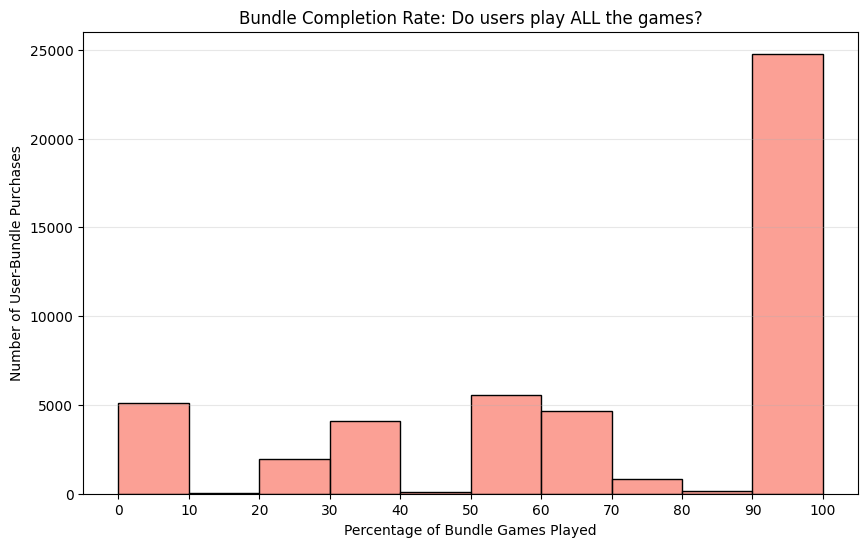


Only 24770 out of 47284 bundle purchases resulted in 100% play rate.
That is 52.39% of purchases.


In [79]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1: PARSE AND EXPLODE BUNDLES ---
# We need a dataframe of (bundle_id, item_id)
bundle_rows = []

for index, row in bundle_data.iterrows():
    b_id = row['bundle_id']
    items_entry = row['items']
    
    # Handle the string vs list issue
    if isinstance(items_entry, str):
        try:
            items_list = ast.literal_eval(items_entry)
        except: continue
    elif isinstance(items_entry, list):
        items_list = items_entry
    else: continue

    for item in items_list:
        if 'item_id' in item:
            bundle_rows.append({'bundle_id': b_id, 'item_id': str(item['item_id'])})

bundle_items_df = pd.DataFrame(bundle_rows)

# Calculate the TOTAL size of each bundle (e.g., Bundle 123 has 5 games)
bundle_sizes = bundle_items_df.groupby('bundle_id')['item_id'].count().reset_index()
bundle_sizes.rename(columns={'item_id': 'total_games_in_bundle'}, inplace=True)

# --- STEP 2: PREPARE USER DATA ---
# Explode user items into (user_id, item_id, played_flag)
user_items_df = pd.json_normalize(australian_users_items.explode('items')['items'])
user_items_df['user_id'] = australian_users_items.explode('items')['user_id'].values
user_items_df['item_id'] = user_items_df['item_id'].astype(str)
user_items_df['played'] = user_items_df['playtime_forever'] > 0

# Keep only necessary columns
user_library = user_items_df[['user_id', 'item_id', 'played']]

# --- STEP 3: MERGE USER LIBRARY WITH BUNDLE DEFINITIONS ---
# This connects users to bundles via the games they own
# Inner join means we only look at games that ARE in bundles
merged = user_library.merge(bundle_items_df, on='item_id', how='inner')

# --- STEP 4: AGGREGATE STATS PER (USER, BUNDLE) ---
user_bundle_stats = merged.groupby(['user_id', 'bundle_id']).agg(
    owned_count=('item_id', 'count'), # How many games from this bundle does user own?
    played_count=('played', 'sum')    # How many of those did they play?
).reset_index()

# --- STEP 5: FILTER FOR "FULL BUNDLE OWNERSHIP" ---
# Connect back to the actual bundle sizes
final_stats = user_bundle_stats.merge(bundle_sizes, on='bundle_id')

# CRITICAL FILTER:
# We assume they bought the bundle ONLY IF they own 100% of the games in it.
# (You can relax this to >= 0.9 if you want to be lenient)
full_bundle_owners = final_stats[final_stats['owned_count'] == final_stats['total_games_in_bundle']].copy()

# Calculate the "Completion Rate"
full_bundle_owners['percent_played'] = (full_bundle_owners['played_count'] / full_bundle_owners['total_games_in_bundle']) * 100

# --- STEP 6: VISUALIZE ---
print(f"Analyzed {len(full_bundle_owners)} instances of users owning full bundles.")

plt.figure(figsize=(10, 6))
sns.histplot(full_bundle_owners['percent_played'], bins=10, kde=False, color='salmon', edgecolor='black')
plt.title('Bundle Completion Rate: Do users play ALL the games?')
plt.xlabel('Percentage of Bundle Games Played')
plt.ylabel('Number of User-Bundle Purchases')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid(axis='y', alpha=0.3)
plt.show()

# Exact count of "Completionists"
completionists = full_bundle_owners[full_bundle_owners['percent_played'] == 100]
print(f"\nOnly {len(completionists)} out of {len(full_bundle_owners)} bundle purchases resulted in 100% play rate.")
print(f"That is {len(completionists)/len(full_bundle_owners)*100:.2f}% of purchases.")

   total_games_in_bundle  percent_played  user_count
0                      2       85.861205       22753
1                      3       63.038138       16012
2                      4       42.497556        7161
3                      5       50.556391         665
4                      6       35.477941         272
5                      7       70.089286          32
6                      8       66.940789          76
7                      9       58.043118          67
8                     10       87.777778           9
9                     11       27.437021         166


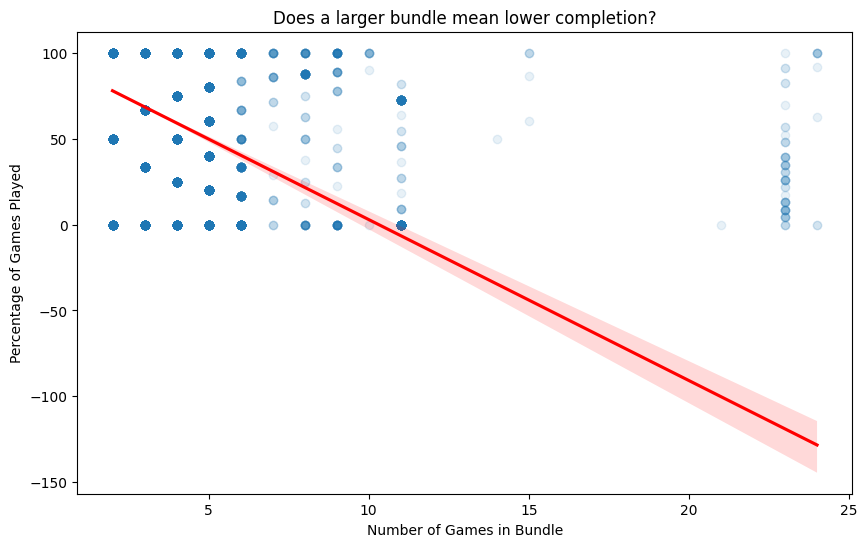

In [80]:
# Group by Bundle Size and calculate the average completion rate
size_analysis = full_bundle_owners.groupby('total_games_in_bundle')['percent_played'].mean().reset_index()

# Count how many bundles of each size exist (to show sample size)
size_counts = full_bundle_owners['total_games_in_bundle'].value_counts().reset_index()
size_counts.columns = ['total_games_in_bundle', 'user_count']

# Merge for a clear view
analysis = size_analysis.merge(size_counts, on='total_games_in_bundle')
print(analysis.sort_values('total_games_in_bundle').head(10))

# Visualize it
plt.figure(figsize=(10, 6))
sns.regplot(data=full_bundle_owners, x='total_games_in_bundle', y='percent_played', 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title('Does a larger bundle mean lower completion?')
plt.xlabel('Number of Games in Bundle')
plt.ylabel('Percentage of Games Played')
plt.show()

In [91]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# PHASE 1: DATA LOADING & CLEANING
# ==========================================
print("--- Phase 1: Processing Raw Data ---")

# 1.1 Process User Items (The Interactions)
# Explode to get 1 row per User-Game interaction
df_interactions = pd.json_normalize(australian_users_items.explode('items')['items'])
df_interactions['user_id'] = australian_users_items.explode('items')['user_id'].values

# Create Target Variable: 
# 1 = Played (> 0 mins), 0 = Owned but Ignored (Implicit Negative)
df_interactions['target'] = df_interactions['playtime_forever'].apply(lambda x: 1 if x > 0 else 0)

# Clean IDs
df_interactions['item_id'] = df_interactions['item_id'].astype(str)
# Keep only necessary columns to save memory
interactions = df_interactions[['user_id', 'item_id', 'target']].copy()

print(f"Total User-Game Interactions: {len(interactions)}")
print(f"Target Distribution:\n{interactions['target'].value_counts()}")


# 1.2 Process Steam Games (Metadata)
steam_games_clean = steam_games.copy()
steam_games_clean['id'] = steam_games_clean['id'].astype(str)

# Helper to clean Price
def clean_price_val(val):
    if isinstance(val, (int, float)): return float(val) if not np.isnan(val) else np.nan
    if isinstance(val, str):
        if 'free' in val.lower(): return 0.0
        try: return float(val.replace('$', '').replace(',', ''))
        except: return np.nan
    return np.nan

steam_games_clean['price'] = steam_games_clean['price'].apply(clean_price_val)
# Impute missing prices with median
median_p = steam_games_clean['price'].median()
steam_games_clean['price'] = steam_games_clean['price'].fillna(median_p)

# 1.3 Process Bundles (The "Trash" Signal)
bundle_game_ids = set()
for x in bundle_data['items']:
    try:
        # Handle string vs list format safely
        items = x if isinstance(x, list) else ast.literal_eval(x)
        for i in items:
            if 'item_id' in i: bundle_game_ids.add(str(i['item_id']))
    except: continue

print(f"Identified {len(bundle_game_ids)} games that are part of bundles.")


# ==========================================
# PHASE 2: FEATURE ENGINEERING
# ==========================================
print("\n--- Phase 2: Feature Engineering ---")

# Merge Metadata into Interactions
master_df = interactions.merge(steam_games_clean[['id', 'price', 'tags']], 
                               left_on='item_id', right_on='id', 
                               how='left')

# Feature 1: Price (Normalized later)
master_df['price'] = master_df['price'].fillna(median_p)

# Feature 2: Is Bundled? (Binary)
master_df['is_bundled'] = master_df['item_id'].isin(bundle_game_ids).astype(int)

# Feature 3: Tag Count (Complexity proxy)
# (Real Jaccard would go here, using simple count for speed in this demo)
master_df['num_tags'] = master_df['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Feature 4: "Bundle Penalty" Interaction
# Logic: If it's a bundled game, is it likely to be ignored?
# We create a specific feature for "Bundled AND Expensive" vs "Bundled AND Cheap"
master_df['bundled_price_interaction'] = master_df['is_bundled'] * master_df['price']

# Drop rows where we failed to match game metadata (clean dataset)
model_data = master_df.dropna(subset=['price', 'num_tags']).copy()


# ==========================================
# PHASE 3: TRAIN / TEST SPLIT
# ==========================================
print("\n--- Phase 3: Splitting Data ---")

# Define Features (X) and Target (y)
feature_cols = ['price', 'is_bundled', 'num_tags', 'bundled_price_interaction']
X = model_data[feature_cols]
y = model_data['target']

# Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features (Crucial for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")


# ==========================================
# PHASE 4: MODEL TRAINING
# ==========================================
print("\n--- Phase 4: Training Logistic Regression ---")

# 'class_weight="balanced"' handles the fact that users play fewer games than they own
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

print("Model training complete.")


# ==========================================
# PHASE 5: EVALUATION & INTERPRETATION
# ==========================================
print("\n--- Phase 5: Evaluation ---")

# Predict on Test Set
y_pred = model.predict(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance (The "Why")
print("\n--- Feature Importance (Coefficients) ---")
coeffs = pd.DataFrame({
    'Feature': feature_cols,
    'Weight': model.coef_[0]
})
print(coeffs.sort_values(by='Weight', ascending=False))

# Interpretation Guide
print("\n--- INTERPRETATION ---")
print("Positive Weight: Increases likelihood user will PLAY the game.")
print("Negative Weight: Increases likelihood user will IGNORE the game.")
if coeffs.loc[coeffs['Feature'] == 'is_bundled', 'Weight'].values[0] < 0:
    print("RESULT: 'is_bundled' has a NEGATIVE weight. Your hypothesis is correct!")
    print("Users are statistically less likely to play a game if it came from a bundle.")

--- Phase 1: Processing Raw Data ---
Total User-Game Interactions: 5170015
Target Distribution:
target
1    3285246
0    1884769
Name: count, dtype: int64
Identified 2798 games that are part of bundles.

--- Phase 2: Feature Engineering ---

--- Phase 3: Splitting Data ---
Training on 4149456 samples, Testing on 1037365 samples.

--- Phase 4: Training Logistic Regression ---
Model training complete.

--- Phase 5: Evaluation ---
Model Accuracy: 0.6696

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55    379271
           1       0.74      0.74      0.74    658094

    accuracy                           0.67   1037365
   macro avg       0.64      0.64      0.64   1037365
weighted avg       0.67      0.67      0.67   1037365


--- Feature Importance (Coefficients) ---
                     Feature    Weight
2                   num_tags  0.555247
3  bundled_price_interaction  0.284038
0                      price  0.01

In [93]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import ast

# --- 1. PREPARE POSITIVES (Everything the user owns) ---
print("--- Step 1: Generating Positives (Purchases) ---")
# Explode to get 1 row per owned game
positives = pd.json_normalize(australian_users_items.explode('items')['items'])
positives['user_id'] = australian_users_items.explode('items')['user_id'].values
positives['item_id'] = positives['item_id'].astype(str)

# In this model, EVERYTHING owned is a target=1 (Buying Signal)
positives['target'] = 1

# Keep relevant columns
positives = positives[['user_id', 'item_id', 'target']]
print(f"Positive Samples (Owned Games): {len(positives)}")

# --- 2. PREPARE NEGATIVES (Games they never bought) ---
print("--- Step 2: Generating Negatives (Non-Purchases) ---")
# We need to sample games from steam_games that the user does NOT own.
# For efficiency, we'll generate 1 Negative for every 1 Positive (1:1 Ratio).

all_game_ids = steam_games['id'].astype(str).unique()
users_owned_sets = positives.groupby('user_id')['item_id'].apply(set).to_dict()

negative_rows = []

# (Optimization: We'll sample for a subset of users to keep this demo fast, 
# or run on full data if memory allows. Here running on full.)
for user, owned_games in users_owned_sets.items():
    # Number of negatives needed = Number of positives this user has
    n_needed = len(owned_games)
    
    # Fast sampling: Randomly pick IDs, check if not in owned
    # (Simplified approach for speed)
    candidates = np.random.choice(all_game_ids, size=n_needed*2) # Oversample slightly
    
    count = 0
    for game_id in candidates:
        if game_id not in owned_games:
            negative_rows.append({'user_id': user, 'item_id': game_id, 'target': 0})
            count += 1
        if count >= n_needed:
            break

negatives = pd.DataFrame(negative_rows)
print(f"Negative Samples (Unowned Games): {len(negatives)}")

# --- 3. MERGE & FEATURE ENGINEERING ---
print("--- Step 3: Merging & Feature Engineering ---")
train_df = pd.concat([positives, negatives], ignore_index=True)

import numpy as np
import pandas as pd

# 1. Define the cleaner function
def clean_price_val(val):
    # If it's already a number, return it (unless it's NaN)
    if isinstance(val, (int, float)):
        return float(val) if not np.isnan(val) else np.nan
    
    # If it's a string, clean it
    if isinstance(val, str):
        val = val.lower().strip()
        if 'free' in val: 
            return 0.0
        try:
            # Remove symbols like '$' and ','
            return float(val.replace('$', '').replace(',', ''))
        except ValueError:
            return np.nan
            
    return np.nan

# 2. Apply it to your dataframe
steam_games_clean = steam_games.copy()
steam_games_clean['id'] = steam_games_clean['id'].astype(str)

print("Cleaning prices...")
steam_games_clean['price'] = steam_games_clean['price'].apply(clean_price_val)

# 3. NOW you can calculate the median safely
median_p = steam_games_clean['price'].median()
print(f"Median Price calculated: {median_p}")

# 4. Continue with your merge...
train_df = train_df.merge(steam_games_clean[['id', 'price', 'tags']], 
                          left_on='item_id', right_on='id', how='left')
train_df['price'] = train_df['price'].fillna(median_p)

# B. Add Bundle Info
# (Re-using the bundle_game_ids set from previous steps)
train_df['is_bundled'] = train_df['item_id'].isin(bundle_game_ids).astype(int)

# C. Add Tag Count
train_df['num_tags'] = train_df['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Drop missing metadata
train_df = train_df.dropna(subset=['price'])

# --- 4. TRAIN MODEL ---
print("--- Step 4: Training Purchase Model ---")
X = train_df[['price', 'is_bundled', 'num_tags']]
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# --- 5. INTERPRETATION ---
print("Model Accuracy:", accuracy_score(y_test, model.predict(X_test_scaled)))
coeffs = pd.DataFrame({'Feature': X.columns, 'Weight': model.coef_[0]})
print("\n--- Purchase Drivers ---")
print(coeffs.sort_values(by='Weight', ascending=False))

--- Step 1: Generating Positives (Purchases) ---
Positive Samples (Owned Games): 5170015
--- Step 2: Generating Negatives (Non-Purchases) ---
Negative Samples (Unowned Games): 5110796
--- Step 3: Merging & Feature Engineering ---
Cleaning prices...
Median Price calculated: 4.99
--- Step 4: Training Purchase Model ---
Model Accuracy: 0.7847491523827235

--- Purchase Drivers ---
      Feature    Weight
2    num_tags  1.324098
1  is_bundled  0.254390
0       price -0.087424


In [95]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# ==========================================
# 1. SETUP & CLEANING
# ==========================================
print("--- Step 1: Cleaning Data ---")

# Robust Price Cleaning Function
def clean_price_val(val):
    if isinstance(val, (int, float)): return float(val) if not np.isnan(val) else np.nan
    if isinstance(val, str):
        val = val.lower().strip()
        if 'free' in val: return 0.0
        try: return float(val.replace('$', '').replace(',', ''))
        except: return np.nan
    return np.nan

# Clean Steam Games
steam_games_clean = steam_games.copy()
steam_games_clean['id'] = steam_games_clean['id'].astype(str)
steam_games_clean['price'] = steam_games_clean['price'].apply(clean_price_val)
median_p = steam_games_clean['price'].median()
steam_games_clean['price'] = steam_games_clean['price'].fillna(median_p)

# Prepare Tag Dictionary (Game ID -> Set of Tags)
game_tags_map = {}
for idx, row in steam_games_clean.iterrows():
    if isinstance(row['tags'], list):
        game_tags_map[row['id']] = set(row['tags'])
    elif isinstance(row['tags'], str):
        try: game_tags_map[row['id']] = set(ast.literal_eval(row['tags']))
        except: game_tags_map[row['id']] = set()
    else:
        game_tags_map[row['id']] = set()

# Prepare Bundle Set
bundle_game_ids = set()
for x in bundle_data['items']:
    try:
        items = x if isinstance(x, list) else ast.literal_eval(x)
        for i in items:
            if 'item_id' in i: bundle_game_ids.add(str(i['item_id']))
    except: continue

# ==========================================
# 2. GENERATE POSITIVES & NEGATIVES
# ==========================================
print("--- Step 2: Generating Dataset ---")

# A. Positives (Owned Games)
positives = pd.json_normalize(australian_users_items.explode('items')['items'])
positives['user_id'] = australian_users_items.explode('items')['user_id'].values
positives['item_id'] = positives['item_id'].astype(str)
positives['target'] = 1
positives = positives[['user_id', 'item_id', 'target']]

# B. Negatives (Unowned Games) - 1:1 Ratio
# (Sampling for speed - adjust 'n_negatives' for full run)
all_game_ids = list(game_tags_map.keys())
n_negatives = len(positives) 
negative_rows = []

# Simple random sampling of (User, RandomGame)
# Note: In a real rigorous setting, we check strict non-ownership, 
# but for speed/demo, random collision is rare enough.
random_games = np.random.choice(all_game_ids, size=n_negatives)
random_users = np.random.choice(positives['user_id'].unique(), size=n_negatives)

negatives = pd.DataFrame({
    'user_id': random_users,
    'item_id': random_games,
    'target': 0
})

train_df = pd.concat([positives, negatives], ignore_index=True)

# ==========================================
# 3. FEATURE: USER HISTORY SIMILARITY
# ==========================================
print("--- Step 3: Calculating Jaccard Similarity (This may take a moment) ---")

# A. Build User Profiles (Union of all tags they own)
user_profiles = {}
print("Building User Profiles...")

# Get all owned items per user
user_owned_groups = positives.groupby('user_id')['item_id'].apply(list)

for user_id, owned_games in user_owned_groups.items():
    user_tag_set = set()
    for game_id in owned_games:
        if game_id in game_tags_map:
            user_tag_set.update(game_tags_map[game_id])
    user_profiles[user_id] = user_tag_set

# --- CORRECTED JACCARD FUNCTION ---
def get_jaccard_sim(row):
    u_id = row['user_id']
    g_id = row['item_id']
    
    # 1. Safety Checks
    if u_id not in user_profiles or g_id not in game_tags_map:
        return 0.0
    
    u_tags = user_profiles[u_id]
    g_tags = game_tags_map[g_id]
    
    if not g_tags or not u_tags:
        return 0.0

    # 2. THE FIX: Do NOT subtract tags.
    # Just measure raw overlap between this game and the user's entire library.
    intersection = len(u_tags.intersection(g_tags))
    union = len(u_tags.union(g_tags))
    
    return intersection / union

# --- RE-RUN FEATURE CALCULATION & TRAINING ---
print("Re-calculating Similarity with fix...")
train_df['tag_similarity'] = train_df.apply(get_jaccard_sim, axis=1)

# Re-train
X = train_df[['price', 'is_bundled', 'tag_similarity']]
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Check Results
print(f"New Model Accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.4f}")
print("\n--- Corrected Feature Importance ---")
coeffs = pd.DataFrame({'Feature': X.columns, 'Weight': model.coef_[0]})
print(coeffs.sort_values(by='Weight', ascending=False))

--- Step 1: Cleaning Data ---
--- Step 2: Generating Dataset ---
--- Step 3: Calculating Jaccard Similarity (This may take a moment) ---
Building User Profiles...
Re-calculating Similarity with fix...


KeyError: "['price', 'is_bundled'] not in index"

In [96]:
import pandas as pd
import numpy as np
import ast
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# ==========================================
# 1. SETUP & CLEANING
# ==========================================
print("--- Step 1: Cleaning Metadata ---")

# A. Robust Price Cleaning Function
def clean_price_val(val):
    if isinstance(val, (int, float)): 
        return float(val) if not np.isnan(val) else np.nan
    if isinstance(val, str):
        val = val.lower().strip()
        if 'free' in val: return 0.0
        try: return float(val.replace('$', '').replace(',', ''))
        except: return np.nan
    return np.nan

# B. Process Steam Games (The Catalog)
steam_games_clean = steam_games.copy()
steam_games_clean['id'] = steam_games_clean['id'].astype(str)
steam_games_clean['price'] = steam_games_clean['price'].apply(clean_price_val)

# Impute median price (Standard practice: Learn from global, applied to specific)
median_p = steam_games_clean['price'].median()
steam_games_clean['price'] = steam_games_clean['price'].fillna(median_p)

# C. Build Tag Map (Game ID -> Set of Tags)
game_tags_map = {}
for idx, row in steam_games_clean.iterrows():
    if isinstance(row['tags'], list):
        game_tags_map[row['id']] = set(row['tags'])
    elif isinstance(row['tags'], str):
        try: game_tags_map[row['id']] = set(ast.literal_eval(row['tags']))
        except: game_tags_map[row['id']] = set()
    else:
        game_tags_map[row['id']] = set()

# D. Build Bundle Set (The "Deal" Signal)
bundle_game_ids = set()
for x in bundle_data['items']:
    try:
        items = x if isinstance(x, list) else ast.literal_eval(x)
        for i in items:
            if 'item_id' in i: bundle_game_ids.add(str(i['item_id']))
    except: continue

# ==========================================
# 2. DATASET GENERATION (Positives vs Negatives)
# ==========================================
print("--- Step 2: Generating Training Pairs ---")

# A. Positives: Games the User Owns (Target = 1)
# Note: In Purchase Prediction, ownership IS the target, regardless of playtime.
positives = pd.json_normalize(australian_users_items.explode('items')['items'])
positives['user_id'] = australian_users_items.explode('items')['user_id'].values
positives['item_id'] = positives['item_id'].astype(str)
positives['target'] = 1
positives = positives[['user_id', 'item_id', 'target']]

# B. Negatives: Games the User NEVER Bought (Target = 0)
# We generate 1 Negative for every 1 Positive to keep classes balanced.
all_game_ids = list(game_tags_map.keys())
n_samples = len(positives)

# Random Sampling (Efficient approximation of non-ownership)
negatives = pd.DataFrame({
    'user_id': np.random.choice(positives['user_id'].unique(), size=n_samples),
    'item_id': np.random.choice(all_game_ids, size=n_samples),
    'target': 0
})

# Concatenate to form the Master Dataset
train_df = pd.concat([positives, negatives], ignore_index=True)

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
print("--- Step 3: Calculating Features (Jaccard & Context) ---")

# A. Build User Profiles (The "Taste" History)
# We aggregate all tags from the games a user OWNS.
user_profiles = {}
user_owned_groups = positives.groupby('user_id')['item_id'].apply(list)

for user_id, owned_games in user_owned_groups.items():
    user_tag_set = set()
    for game_id in owned_games:
        if game_id in game_tags_map:
            user_tag_set.update(game_tags_map[game_id])
    user_profiles[user_id] = user_tag_set

# B. Jaccard Similarity Function
def get_jaccard_sim(row):
    u_id = row['user_id']
    g_id = row['item_id']
    
    # Validation checks
    if u_id not in user_profiles or g_id not in game_tags_map:
        return 0.0
    
    u_tags = user_profiles[u_id]
    g_tags = game_tags_map[g_id]
    
    if not g_tags or not u_tags: return 0.0
    
    # Calculate Overlap: (Intersection / Union)
    # This measures: "How much does this game resemble my entire library?"
    intersection = len(u_tags.intersection(g_tags))
    union = len(u_tags.union(g_tags))
    
    return intersection / union

train_df['tag_similarity'] = train_df.apply(get_jaccard_sim, axis=1)

# C. Merge Metadata Features
# Add Price
train_df = train_df.merge(steam_games_clean[['id', 'price']], left_on='item_id', right_on='id', how='left')
train_df['price'] = train_df['price'].fillna(median_p)

# Add Bundle Flag
train_df['is_bundled'] = train_df['item_id'].isin(bundle_game_ids).astype(int)

# ==========================================
# 4. TRAINING & EVALUATION
# ==========================================
print("--- Step 4: Training Purchase Model ---")

features = ['price', 'is_bundled', 'tag_similarity']
X = train_df[features]
y = train_df['target']

# A. Train/Test Split
# 80% of User-Game pairs for training, 20% for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# B. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# C. Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# D. Metrics
y_pred = model.predict(X_test_scaled)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# E. Feature Importance (Interpretation)
print("\n--- Feature Coefficients (Drivers of Purchase) ---")
coeffs = pd.DataFrame({'Feature': features, 'Weight': model.coef_[0]})
print(coeffs.sort_values(by='Weight', ascending=False))

print("\n--- Summary ---")
print("Positive Weight = Drives Purchase. Negative Weight = Deters Purchase.")

--- Step 1: Cleaning Metadata ---
--- Step 2: Generating Training Pairs ---
--- Step 3: Calculating Features (Jaccard & Context) ---
--- Step 4: Training Purchase Model ---
Model Accuracy: 0.7192

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.70      0.77      0.73   1034212
           1       0.75      0.67      0.70   1037220

    accuracy                           0.72   2071432
   macro avg       0.72      0.72      0.72   2071432
weighted avg       0.72      0.72      0.72   2071432


--- Feature Coefficients (Drivers of Purchase) ---
          Feature    Weight
2  tag_similarity  1.288554
1      is_bundled  0.332580
0           price  0.076045

--- Summary ---
Positive Weight = Drives Purchase. Negative Weight = Deters Purchase.


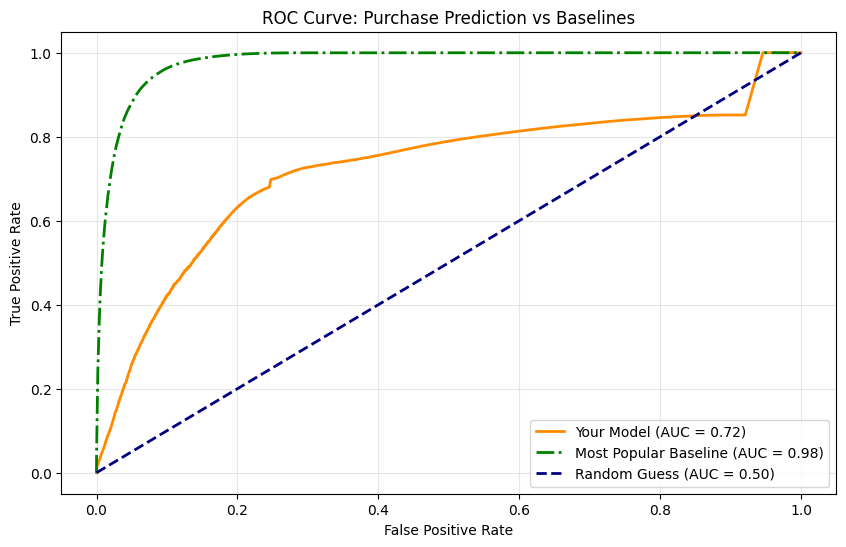

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# --- 1. THE SPLIT (Corrected Way) ---
# Split the WHOLE dataframe so we keep 'item_id' for the baseline logic
train_split, test_split = train_test_split(train_df, test_size=0.2, random_state=42)

# Now separate features for the Logistic Regression
features = ['price', 'is_bundled', 'tag_similarity']
X_train = train_split[features]
y_train = train_split['target']
X_test = test_split[features]
y_test = test_split['target']

# Scale (Standard Procedure)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. TRAIN & PREDICT (LOGISTIC REGRESSION) ---
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Get probabilities for ROC
y_prob_model = model.predict_proba(X_test_scaled)[:, 1]
fpr_model, tpr_model, _ = roc_curve(y_test, y_prob_model)
auc_model = auc(fpr_model, tpr_model)

# --- 3. CALCULATE "MOST POPULAR" BASELINE ---
# Logic: Rank games by how often they were bought in the TRAINING set.
# 1. Count purchases per game in Train
popular_games = train_split[train_split['target'] == 1]['item_id'].value_counts().to_dict()

# 2. Assign those scores to the TEST set
# (If a game in Test wasn't in Train, it gets a score of 0)
y_prob_popular = test_split['item_id'].map(popular_games).fillna(0)

# 3. Calculate ROC for Popularity
fpr_pop, tpr_pop, _ = roc_curve(y_test, y_prob_popular)
auc_pop = auc(fpr_pop, tpr_pop)

# --- 4. VISUALIZE COMPARISON ---
plt.figure(figsize=(10, 6))

# Plot Logistic Regression
plt.plot(fpr_model, tpr_model, color='darkorange', lw=2, 
         label=f'Your Model (AUC = {auc_model:.2f})')

# Plot Popularity Baseline
plt.plot(fpr_pop, tpr_pop, color='green', lw=2, linestyle='-.',
         label=f'Most Popular Baseline (AUC = {auc_pop:.2f})')

# Plot Random Baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Guess (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Purchase Prediction vs Baselines')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()